In [48]:
import warnings
warnings.simplefilter('ignore')
from sklearn import tree
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [49]:
# Create df without NaNs
deaths = pd.read_csv('Data/Opioid_Related_Deaths_2012-2018.csv')
deaths_nonan = deaths.dropna(subset=['Age', 'Sex','Race','DeathCity'])
deaths_nonan.count()

ID                      4494
Date                    4494
Age                     4494
Sex                     4494
Race                    4494
ResidenceCity           4341
ResidenceCounty         3813
ResidenceState          3218
DeathCity               4494
DeathCounty             3507
Location                4479
LocationifOther          534
DescriptionofInjury     3819
InjuryPlace             4444
InjuryCity              3048
InjuryCounty            2153
InjuryState             1288
COD                     4494
Heroin                  4494
Synthetic Opioids       4494
Prescription Opioids    4494
DeathCityGeo            4494
DeathCityLat            4494
DeathCityLong           4494
Drug_Category           4494
Drug_Type               4494
dtype: int64

In [50]:
# Clean up data with only columns needed
deaths_forML = deaths_nonan[['Age', 'Sex', 'Race', 'DeathCity', 'Drug_Category'
       ]]
deaths_forML.head()

,Age,Sex,Race,DeathCity,Drug_Category
1,30.0,Female,White,Danbury,Heroin
2,23.0,Male,White,Greenwich,Heroin
3,22.0,Male,Asian,Greenwich,Synthetic Opioids
4,23.0,Male,White,Bristol,Heroin
5,21.0,Female,White,West Hartford,Heroin


In [51]:
# Reshape data
X = deaths_forML[["Age", "Sex", "Race"]]
y = deaths_forML["Drug_Category"].values.reshape(-1, 1)
print(X.shape, y.shape)
y

(4494, 3) (4494, 1)


array([['Heroin'],
       ['Heroin'],
       ['Synthetic Opioids'],
       ...,
       ['Heroin'],
       ['Synthetic Opioids'],
       ['Heroin']], dtype=object)

In [52]:
# Reformat data to numeric



# y = pd.get_dummies(deaths_forML['Drug_Category'])
X = pd.get_dummies(X)

# data = deaths_forML.values

# X = data[:, 0:4]
# y = data[:, 4]



In [7]:
# from sklearn.preprocessing import LabelEncoder

# # Step 1: Label-encode data set
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# encoded_y = label_encoder.transform(y)

In [8]:
# for label, original_class in zip(encoded_y, y):
#     print('Original Class: ' + str(original_class))
#     print('Encoded Label: ' + str(label))
#     print('-' * 12)

In [9]:
# from keras.utils import to_categorical

# # Step 2: One-hot encoding
# one_hot_y = to_categorical(encoded_y)
# one_hot_y

In [53]:
from sklearn.model_selection import train_test_split

# X = pd.get_dummies(X)
# y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

,Age,Sex_Female,Sex_Male,Sex_Unknown,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_Unknown,Race_White
3594,60.0,0,1,0,0,0,0,0,0,1
1413,46.0,0,1,0,0,0,0,0,0,1
1150,49.0,0,1,0,0,0,0,0,0,1
105,36.0,1,0,0,0,0,0,0,0,1
3834,48.0,1,0,0,0,0,0,0,0,1


In [115]:
# from sklearn.preprocessing import StandardScaler
# X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)

# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)
# y_train_scaled = y_scaler.transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)

In [147]:
# feature_names = data.columns

In [45]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5435943060498221

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200) # nj
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.5293594306049823

In [13]:
# sorted(zip(rf.feature_importances_, feature_names), reverse=True)

NameError: name 'feature_names' is not defined

In [54]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score

def evaluate(pipeline, X_train, X_test, y_train, y_test):
    '''
    Evaluate a pipeline on training and test datasets
    '''    
    pipeline.fit(X_train, y_train)
    y_train_hat = pipeline.predict(X_train)
    y_test_hat = pipeline.predict(X_test)
    train_f1 = f1_score(y_train_hat, y_train, average='micro')
    train_acc = accuracy_score(y_train_hat, y_train)
    test_f1 = f1_score(y_test_hat, y_test,average='micro')
    test_acc = accuracy_score(y_test_hat, y_test)

    print(f"========== Predictor: {type(pipeline).__name__} ==========")
    print(f"Training result: f1: {train_f1:.3f}, acc: {train_acc:.3f}")
    print(f"Test result: f1: {test_f1:.3f}, acc: {test_acc:.3f}")
    print()
    
xgb_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 400],
    'max_depth': np.arange(5, 20),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': np.arange(0.5, 1.0, 0.05),
    'min_child_weight': np.arange(1, 10),
    'colsample_bytree': np.arange(0.2, 1.0, 0.1),
    'gamma': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 1e-2],
    'average': 'micro',
    'n_jobs': [-1]
}

predictor = XGBClassifier()
rs = RandomizedSearchCV(predictor, xgb_param_grid, cv=5, scoring='f1_micro',n_jobs=-1, n_iter=100, verbose=1)
rs.fit(X_train, y_train)
evaluate(rs.best_estimator_, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.5min finished


========== Predictor: XGBClassifier ==========
Training result: f1: 0.576, acc: 0.576
Test result: f1: 0.557, acc: 0.557



In [46]:

xgb = XGBClassifier()
xgb = xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)


0.5569395017793595

In [145]:
sorted(zip(xgb.feature_importances_, feature_names), reverse=True)

[(0.07654272, 'Sex_Male'),
 (0.050103355, 'DeathCity_BARKHAMSTED'),
 (0.045126807, 'DeathCity_ANSONIA'),
 (0.038777277, 'DeathCity_BROAD BROOK'),
 (0.03872366, 'Race_Hispanic, Black'),
 (0.03445757, 'DeathCity_06340'),
 (0.030918261, 'Race_Hispanic, White'),
 (0.029108504, 'DeathCity_DANBURY'),
 (0.027994782, 'DeathCity_BLOOMFIELD'),
 (0.025250094, 'DeathCity_ANDOVER'),
 (0.025104737, 'Race_Asian, Other'),
 (0.02509941, 'DeathCity_COLCHESTER'),
 (0.02470582, 'Race_Unknown'),
 (0.02401996, 'DeathCity_BEACON FALLS'),
 (0.022296716, 'DeathCity_CHESTER'),
 (0.02222953, 'DeathCity_CANTON'),
 (0.021522343, 'DeathCity_AMSTON'),
 (0.02131508, 'Age'),
 (0.020436283, 'DeathCity_COVENTRY'),
 (0.018449131, 'DeathCity_BANTAM'),
 (0.018040428, 'DeathCity_BETHLEHEM'),
 (0.017695932, 'DeathCity_BETHANY'),
 (0.017312381, 'DeathCity_BRISTOL'),
 (0.016683219, 'DeathCity_CLINTON'),
 (0.0159884, 'DeathCity_CORNWALL BRIDGE'),
 (0.015901862, 'Sex_Female'),
 (0.015862763, 'DeathCity_BOLTON'),
 (0.015757903, 'Race_Native American, Other'),
 (0.015467903, 'DeathCity_BURLINGTON'),
 (0.015330357, 'DeathCity_BRIDGEWATER'),
 (0.01507279, 'DeathCity_CHAPLIN'),
 (0.015055721, 'Race_White'),
 (0.014856879, 'DeathCity_BETHEL'),
 (0.013425637, 'DeathCity_BOZRAH'),
 (0.013076861, 'DeathCity_ASHFORD'),
 (0.012618673, 'DeathCity_BALTIC'),
 (0.012467052, 'DeathCity_COLUMBIA'),
 (0.011834606, 'DeathCity_BROOKLYN'),
 (0.0116438605, 'Race_Other'),
 (0.01143453, 'DeathCity_BAKERSVILLE'),
 (0.011273795, 'DeathCity_BRIDGEPORT'),
 (0.010776334, 'DeathCity_CANTERBURY'),
 (0.010246851, 'Race_Black'),
 (0.010120965, 'Race_Chinese'),
 (0.00880893, 'DeathCity_BRANFORD'),
 (0.0075782025, 'DeathCity_CHESHIRE'),
 (0.0074999398, 'Race_Asian Indian'),
 (0.0066039693, 'DeathCity_CROMWELL'),
 (0.0048634447, 'DeathCity_CENTRAL VILLAGE'),
 (0.0045177955, 'DeathCity_COS COB'),
 (0.0, 'Sex_Unknown'),
 (0.0, 'Race_Hawaiian'),
 (0.0, 'DeathCity_BROOKFIELD'),
 (0.0, 'DeathCity_BERLIN'),
 (0.0, 'DeathCity_AVON')]

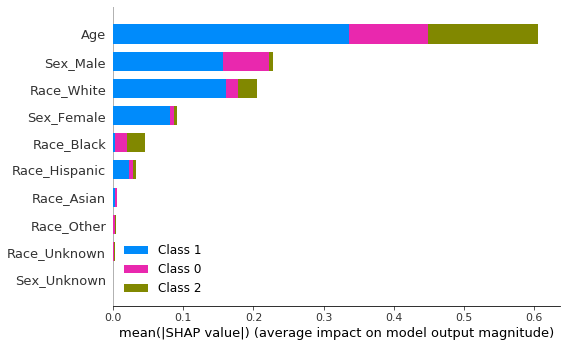

In [47]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,plot_type="bar")